In [5]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from astropy.table import Table, vstack

# Everything above should import with no issue, everything below needs directing
homepath = "/global/homes/c/cpopik/"
packpath = homepath + "Packages/"

import camb
sys.path.append(packpath + "hmvec/")
import hmvec as hm

sys.path.append(packpath+"ostrich/src/pality/")
import pality
sys.path.append(packpath+'ostrich/')
import ostrich
sys.path.append(packpath+"emu_CAMELS/scripts/1P_emulator")
import helper_functions_1P as fs

In [2]:
home=packpath+'emu_CAMELS/emulator_profiles/1P_set/' #point to your profiles
suite='SIMBA'  # Simulation suite to emulate (SIMBA, IllustrisTNG)
vary_str='ASN1'  # Feedback parameter (ASN1/2, AAGN1/2)
prof='pth_mean' # Profile to output (rho_mean, rho_med, pth_mean, pth_med)
func_str='linear' #this is the Rbf interpolation function


#  Currently understand these to be inherent parameters of the simulation suite
mass=fs.mass
mass_str=fs.mass_str
snap=fs.snap
z=fs.choose_redshift(suite)
vary,sims=fs.choose_vary(vary_str)
samples=fs.cartesian_prod(vary,z,mass)
nsamp=samples.shape[0]

samples,x,y,emulator=fs.build_emulator_3D(home,suite,vary_str,prof,func_str)

In [3]:
#now we can get an emulated profile with different parameters
A = 0.7 # feedback parameter
z = 0.2 # redshift
logM = 13.7 # halo mass in log10 Msun

params=[[A, z, logM]] #the order here is important- A, then z, then logM
log10_emulated_pth_mean = emulator(params)

Text(0, 0.5, '$P_{th} \\ [g\\, cm^{-1}\\, s^{-2}]$')

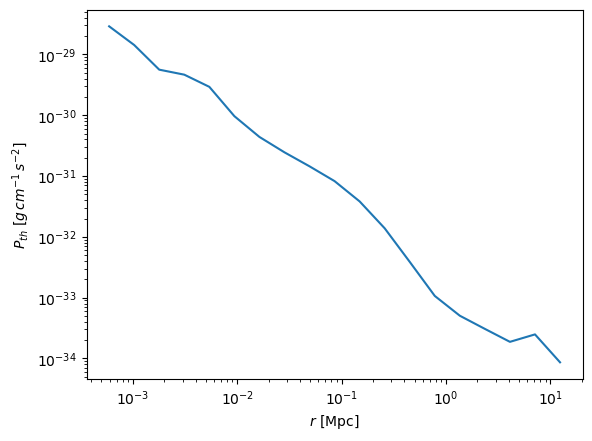

In [4]:
sigma_T = 6.6524e-25  # cm^2
mec2 = 9.1094e-28 * (2.998e10)**2  # ergs

xs=x

constants = (sigma_T/mec2)
emupk = constants*10**log10_emulated_pth_mean

plt.loglog(x,emupk)
plt.xlabel(r'$r \ [{\rm Mpc}]$')
plt.ylabel(r'$P_{th} \ [g\, cm^{-1}\, s^{-2}]$')

# Get to right format

In [8]:
logMs = np.linspace(11.5, 15, 200)

# Create model
zs = np.linspace(0.,3.,20)  # 20, DOES change MCMC time
# ms = np.geomspace(2e10,1e17,200)  # 200, DOES change MCMC time
ms = np.geomspace(10**12.5,10**max(logMs),200)
ks = np.geomspace(1e-4,100,1001)  # 1001, doesn't really change MCMC time
hcos = hm.HaloModel(zs,ks,ms=ms)

xmax = 20  # 20, doesn't really change MCMC time
nxs = 5000  # 5000, DOES change MCMC Time

In [33]:
hcos.add_battaglia_pres_profile("y",family='pres', xmax=xmax,nxs=nxs, ignore_existing=True)

/global/homes/c/cpopik/Packages/hmvec/hmvec/fft.py:90: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


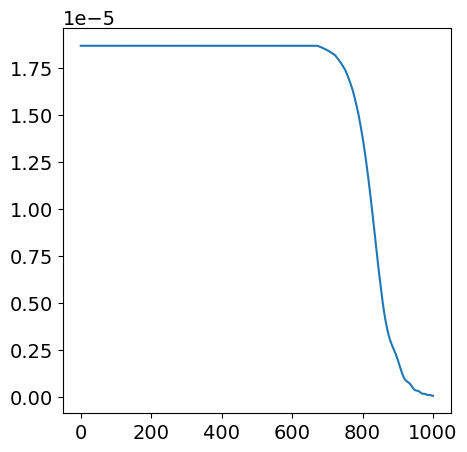

In [56]:
halomodelpk = hcos.pk_profiles['y']
plt.plot(halomodelpk[0,0])

In [57]:
R_scale=1

Pths = constants*10**log10_emulated_pth_mean[:,0]
xs = x
cmaxs = np.max(xs)[..., None, None]/R_scale
rss = np.array([R_scale])
zsemu = np.array([z])
ksemu = ks

ks, emuprofilehm_TEST = hm.fft.generic_profile_fft_new(Pths, xs, cmaxs, rss, zsemu, ksemu)

Pyyemu_TEST = hcos.get_power_custom(emuprofilehm_TEST, 'pressure',
                      emuprofilehm_TEST, 'pressure')

Check the consistency relation for tSZ
Check the consistency relation for tSZ
Two-halo consistency1:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] [[0.00049955 0.00049955 0.00049955 ... 0.         0.         0.        ]
 [0.00052704 0.00052704 0.00052704 ... 0.         0.         0.        ]
 [0.00055321 0.00055321 0.00055321 ... 0.         0.         0.        ]
 ...
 [0.00030114 0.00030114 0.00030114 ... 0.         0.         0.        ]
 [0.00026335 0.00026335 0.00026335 ... 0.         0.         0.        ]
 [0.00022783 0.00022783 0.00022783 ... 0.         0.         0.        ]]
Two-halo consistency2:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] [[0.00049955 0.00049955 0.00049955 ... 0.         0.         0.        ]
 [0.00052704 0.00052704 0.00052704 ... 0.         0.         0.        ]
 [0.00055321 0.00055321 0.00055321 ... 0. 

/global/homes/c/cpopik/Packages/hmvec/hmvec/fft.py:142: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


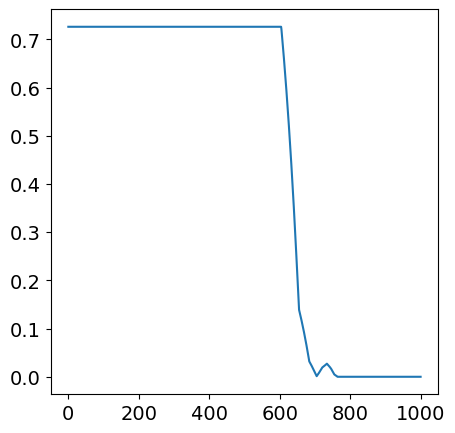

In [58]:
plt.plot(emuprofilehm_TEST[0, 0])

In [59]:
Pyyemu_TEST.shape

(20, 1001)

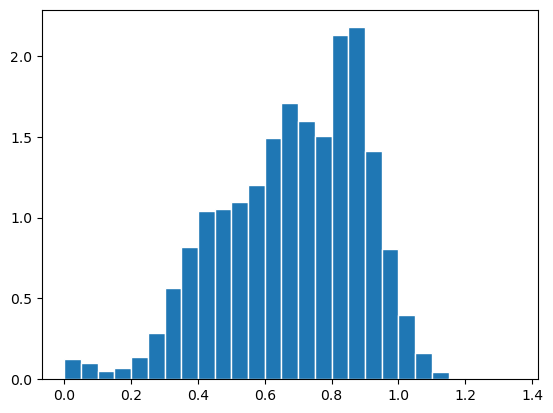

In [6]:
table = Table.read(homepath + '/Results/DESI_LRGs_ACTD56.csv')
targetdata = table.to_pandas()

# Sets RA limits to match ACT maps
targetdata['RA'].where(targetdata['RA'] < 180, targetdata['RA'] - 360, inplace=True)

data_zs = targetdata['Z_PHOT_MEAN'].values
area = (max(targetdata.RA)-min(targetdata.RA))*(max(targetdata.DEC)-min(targetdata.DEC))

gdndz, gzs = plt.hist(data_zs, bins=np.arange(0, 1.4, 0.05), ec='w', weights=np.ones(len(data_zs))/area, density=True)[0:2]

In [62]:
ls = np.linspace(0, 6000, 6001)

C_yy_TEST = hcos.C_gg_new(ls, hcos.zs, hcos.ks, Pyyemu_TEST, gzs=gzs[1:], gdndz=gdndz)

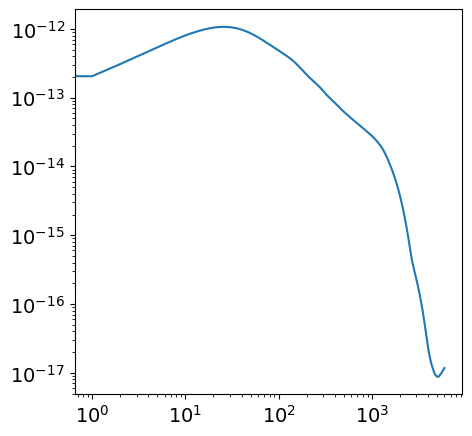

In [63]:
plt.plot(ls, C_yy_TEST)
plt.xscale('log')
plt.yscale('log')

In [ ]:
np.save(homepath+'/Results/EmilyEmulatorCggFirstTest.npy', C_gg_TEST)

# Looping

In [13]:
def emulatorloop(A, zs, logMs):
    zslist = []
    for i in range(len(zs)):
        logMslist = []
        for j in range(len(logMs)):
            logMslist.append(10**emulator([[A, zs[i], logMs[j]]])[:,0])
        zslist.append(np.stack(logMslist))
    emulatorset = np.stack(zslist)
    return emulatorset

In [14]:
zsgrid = np.meshgrid(hcos.zs, np.log10(hcos.ms))[0]
msgrid = np.meshgrid(hcos.zs, np.log10(hcos.ms))[1]
Asgrid = 0.7*np.ones(zsgrid.shape)

test1 = np.array((Asgrid, zsgrid, msgrid)).T.reshape(hcos.zs.size*hcos.ms.size, 3)
testresults = 10**(emulator(test1).T.reshape(hcos.zs.size, hcos.ms.size, xs.size))

testtry = emulatorloop(0.7, hcos.zs, np.log10(hcos.ms))
(testresults - testtry)/testresults

array([[[ 8.15908698e-15,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  2.44800123e-14],
        [-8.16278787e-15,  0.00000000e+00,  8.24921531e-15, ...,
          0.00000000e+00,  8.11242354e-15, -1.64287484e-14],
        [ 1.64848148e-14,  8.22419377e-15,  0.00000000e+00, ...,
         -8.25818908e-15,  0.00000000e+00,  2.46355339e-14],
        ...,
        [ 3.26216202e-14,  4.09215648e-14,  8.23662088e-15, ...,
         -4.09719055e-14, -3.27328210e-14, -1.47273495e-13],
        [-9.81866789e-14, -3.27994584e-14,  8.22408011e-15, ...,
          8.12338703e-15,  8.17795832e-15, -3.27400845e-14],
        [-3.26695066e-14, -4.08891270e-14, -8.21168355e-15, ...,
          0.00000000e+00,  8.17275839e-15, -5.73164213e-14]],

       [[-2.46559880e-14, -8.23836198e-15, -8.14744755e-15, ...,
          8.03616760e-15,  0.00000000e+00,  3.27740739e-14],
        [ 0.00000000e+00, -8.26139351e-15, -8.06007295e-15, ...,
          0.00000000e+00, -8.14409055e

In [15]:
zsgrid = np.meshgrid(hcos.zs, np.log10(hcos.ms))[0]
msgrid = np.meshgrid(hcos.zs, np.log10(hcos.ms))[1]

A = 0.7

import time
t0 = time.time()
testtry = emulatorloop(A, hcos.zs, np.log10(hcos.ms))
t1 = time.time()
print(t1-t0)

t2 = time.time()
Asgrid = A*np.ones(zsgrid.shape)
test1 = np.array((Asgrid, zsgrid, msgrid)).T.reshape(hcos.zs.size*hcos.ms.size, 3)
testresults = 10**(emulator(test1).T.reshape(hcos.zs.size, hcos.ms.size, xs.size))
t3 = time.time()
print(t3-t2)

print(max(np.ndarray.flatten((testresults - testtry)/testresults)),
      np.mean(np.ndarray.flatten((testresults - testtry)/testresults)))

0.9113674163818359
0.1108863353729248
2.536154965501832e-13 -2.6876458050929207e-16


In [16]:
R_scale=1

zsemu, ksemu, msemu = hcos.zs, hcos.ks, hcos.ms

rhos = emulatorloop(0.7, zs, np.log10(msemu))  # Dimensions should be (zdim, mdim, xdim)
xs = x  # dimensions should be (xdim)
rss = np.array([R_scale]) * np.ones((zsemu.size, msemu.size, 1))  # Dimension should be (zdim, mdim, 1)
cmaxs = np.max(xs)/R_scale * np.ones((zsemu.size, msemu.size))  # Dimension should be (zim, mdim)

In [17]:
ksemuhm, profileemuhm = hm.fft.generic_profile_fft_new(rhos, xs, cmaxs, rss, zsemu, ksemu)

Pggemu = hcos.get_power_custom(profileemuhm, 'matter',
                      profileemuhm, 'matter')

ls = np.linspace(0, 6000, 6001)

C_gg_emu = hcos.C_gg_new(ls, hcos.zs, hcos.ks, Pggemu, gzs=gzs[1:], gdndz=gdndz)

/global/homes/c/cpopik/hmvec/hmvec/fft.py:142: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


Two-halo consistency1:  [[0.42384731]
 [0.41764891]
 [0.40490602]
 [0.386425  ]
 [0.36363122]
 [0.33808742]
 [0.31115485]
 [0.2838601 ]
 [0.25691291]
 [0.23078738]
 [0.20580343]
 [0.18218409]
 [0.16008733]
 [0.13962125]
 [0.12085151]
 [0.10380499]
 [0.08847354]
 [0.07481772]
 [0.06277147]
 [0.05224691]] [[3.80387342 3.80387342 3.80387342 ... 0.         0.         0.        ]
 [3.9516617  3.9516617  3.9516617  ... 0.         0.         0.        ]
 [4.10544649 4.10544649 4.10544649 ... 0.         0.         0.        ]
 ...
 [0.91074432 0.91074432 0.91074432 ... 0.         0.         0.        ]
 [0.73919088 0.73919088 0.73919088 ... 0.         0.         0.        ]
 [0.59570392 0.59570392 0.59570392 ... 0.         0.         0.        ]]
Two-halo consistency2:  [[0.42384731]
 [0.41764891]
 [0.40490602]
 [0.386425  ]
 [0.36363122]
 [0.33808742]
 [0.31115485]
 [0.2838601 ]
 [0.25691291]
 [0.23078738]
 [0.20580343]
 [0.18218409]
 [0.16008733]
 [0.13962125]
 [0.12085151]
 [0.10380499]
 [0

In [18]:
Pggemu, Pggemu_TEST

(array([[4.11408581e+04, 4.16921892e+04, 4.22508922e+04, ...,
         1.89100268e-04, 1.81915055e-04, 1.74999078e-04],
        [3.72870785e+04, 3.77867744e+04, 3.82931521e+04, ...,
         1.63427229e-04, 1.57217485e-04, 1.51240426e-04],
        [3.39070410e+04, 3.43614438e+04, 3.48219236e+04, ...,
         1.44409740e-04, 1.38922541e-04, 1.33640953e-04],
        ...,
        [8.43876002e+02, 8.55186814e+02, 8.66648952e+02, ...,
         5.70443943e-05, 5.48743529e-05, 5.27856568e-05],
        [6.48029329e+02, 6.56715110e+02, 6.65517073e+02, ...,
         5.39188893e-05, 5.18674912e-05, 4.98929944e-05],
        [5.07492306e+02, 5.14294439e+02, 5.21187583e+02, ...,
         5.09425223e-05, 4.90041145e-05, 4.71383758e-05]]),
 array([[4.90641332e+04, 4.97216576e+04, 5.03879743e+04, ...,
         1.89100268e-04, 1.81915055e-04, 1.74999078e-04],
        [4.05443451e+04, 4.10877014e+04, 4.16383236e+04, ...,
         1.63427229e-04, 1.57217485e-04, 1.51240426e-04],
        [3.26723023e+04, 

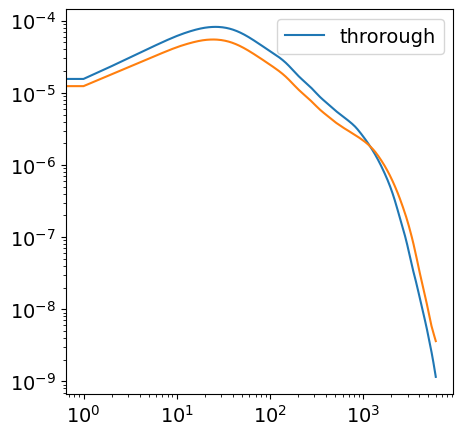

In [19]:
plt.plot(ls, C_gg_emu, label='throrough')
plt.plot(ls, C_gg_TEST)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [242]:
name='new'
family=None
param_override=None
nxs=None
xmax=None
ignore_existing=False

if not(ignore_existing): assert name not in hcos.uk_profiles.keys(), "Profile name already exists."
assert name!='nfw', "Name nfw is reserved."
if nxs is None: nxs = hcos.p['electron_density_profile_integral_numxs']
if xmax is None: xmax = hcos.p['electron_density_profile_integral_xmax']


# Set default parameters
if family is None: family = hcos.p['battaglia_gas_family'] # AGN or SH?
pparams = {}
pparams['battaglia_gas_gamma'] = hcos.p['battaglia_gas_gamma']
pparams.update(hm.battaglia_defaults[family])

# Update with overrides
if param_override is not None:
#            print(param_override)
    for key in param_override.keys():
        if key=='battaglia_gas_gamma':
            pparams[key] = param_override[key]
        elif key in battaglia_defaults[family]:
            pparams[key] = param_override[key]
        else:
            #raise ValueError # param in param_override doesn't seem to be a Battaglia parameter
            pass

# Convert masses to m200critz
rhocritz = hcos.rho_critical_z(hcos.zs)
if hcos.mdef=='vir':
    delta_rhos1 = rhocritz*hcos.deltav(hcos.zs)
elif hcos.mdef=='mean':
    delta_rhos1 = hcos.rho_matter_z(hcos.zs)*200.
rvirs = hcos.rvir(hcos.ms[None,:],hcos.zs[:,None])
cs = hcos.concentration()
delta_rhos2 = 200.*hcos.rho_critical_z(hcos.zs)
m200critz = hm.mdelta_from_mdelta(hcos.ms,cs,delta_rhos1,delta_rhos2)
r200critz = hm.R_from_M(m200critz,hcos.rho_critical_z(hcos.zs)[:,None],delta=200.)

# Generate profiles
"""
The physical profile is rho(r) = f(2r/R200)
We rescale this to f(x), so x = r/(R200/2) = r/rgs
So rgs = R200/2 is the equivalent of rss in the NFW profile
"""
omb = hcos.p['ombh2'] / hcos.h**2.
omm = hcos.om0
rhofunc = lambda x: hm.rho_gas_generic_x(x,m200critz[...,None],hcos.zs[:,None,None],omb,omm,rhocritz[...,None,None],
                            gamma=pparams['battaglia_gas_gamma'],
                            rho0_A0=pparams['rho0_A0'],
                            rho0_alpham=pparams['rho0_alpham'],
                            rho0_alphaz=pparams['rho0_alphaz'],
                            alpha_A0=pparams['alpha_A0'],
                            alpha_alpham=pparams['alpha_alpham'],
                            alpha_alphaz=pparams['alpha_alphaz'],
                            beta_A0=pparams['beta_A0'],
                            beta_alpham=pparams['beta_alpham'],
                            beta_alphaz=pparams['beta_alphaz'])

rgs = r200critz/2.
cgs = rvirs/rgs
ks,ukouts = hm.fft.generic_profile_fft(rhofunc,cgs,rgs[...,None],hcos.zs,hcos.ks,xmax,nxs)

/global/homes/c/cpopik/hmvec/hmvec/fft.py:90: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [249]:
xs = np.linspace(0.,xmax,nxs+1)[1:]
rhos = rhofunc_x(xs)
if rhos.ndim==1:
    rhos = rhos[None,None]
else:
    assert rhos.ndim==3
rhos = rhos + cmaxs[...,None]*0.
theta = np.ones(rhos.shape)
theta[np.abs(xs)>cmaxs[...,None]] = 0 # CHECK
# m
integrand = theta * rhos * xs**2.
mnorm = np.trapz(integrand,xs) # mass but off by norm same as rho is off by
if not(do_mass_norm):
    mnorm *= 0
    mnorm +=1
# u(kt)
integrand = rhos*theta
kts,ukts = fft_integral(xs,integrand)
uk = ukts/kts[None,None,:]/mnorm[...,None]
kouts = kts/rss/(1+zs[:,None,None]) # divide k by (1+z) here for comoving FIXME: check this!
ukouts = np.zeros((uk.shape[0],uk.shape[1],ks.size))
# sadly at this point we must loop to interpolate :(
# from orphics import io
# pl = io.Plotter(xyscale='loglog')
for i in range(uk.shape[0]):
    for j in range(uk.shape[1]):
        pks = kouts[i,j]
        puks = uk[i,j]
        puks = puks[pks>0]
        pks = pks[pks>0]
        ukouts[i,j] = np.interp(ks,pks,puks,left=puks[0],right=0)
        #TODO: Add compulsory debug plot here
#         pl.add(ks,ukouts[i,j])
# pl.hline(y=1)

NameError: name 'rhofunc_x' is not defined

# Final Usable block

In [10]:
home='/global/homes/c/cpopik/emu_CAMELS/emulator_profiles/' #point to your profiles
suite='SIMBA'  # Simulation suite to emulate (SIMBA, IllustrisTNG)
vary_str='ASN1'  # Feedback parameter (ASN1/2, AAGN1/2)
prof='pth_mean' # Profile to output (rho_mean, rho_med, pth_mean, pth_med)
func_str='linear' #this is the Rbf interpolation function

#  Currently understand these to be inherent parameters of the simulation suite
mass=fs.mass
mass_str=fs.mass_str
snap=fs.snap
z=fs.choose_redshift(suite)
vary,sims=fs.choose_vary(vary_str)
samples=fs.cartesian_prod(vary,z,mass)
nsamp=samples.shape[0]

samples,x,y,emulator=fs.build_emulator_3D(home,suite,vary_str,prof,func_str)

FileNotFoundError: /global/homes/c/cpopik/emu_CAMELS/emulator_profiles/SIMBA/SIMBA_1P_22_033_uw_11-11.5.txt not found.

In [21]:
zsgrid = np.meshgrid(hcos.zs, np.log10(hcos.ms))[0]
msgrid = np.meshgrid(hcos.zs, np.log10(hcos.ms))[1]

def emu_profiles(A):
    Asgrid = A*np.ones(zsgrid.shape)
    params = np.array((Asgrid, zsgrid, msgrid)).T.reshape(hcos.zs.size*hcos.ms.size, 3)
    profiles = 10**(emulator(params).T.reshape(hcos.zs.size, hcos.ms.size, xs.size))
    return profiles

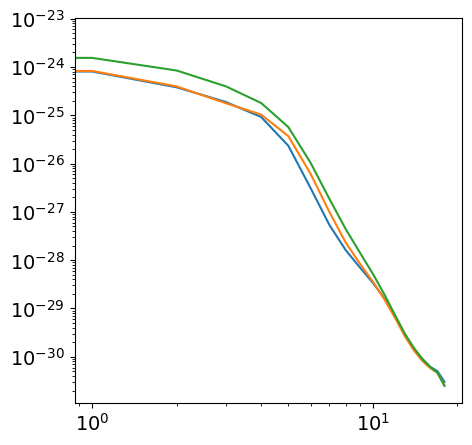

In [22]:
plt.plot(emu_profiles(0.2)[0,0])
plt.plot(emu_profiles(1.2)[0,0])
plt.plot(emu_profiles(3)[0,0])
plt.xscale('log')
plt.yscale('log')

In [58]:
A = 0.2
R_scale=1

rhos = emu_profiles(A)  # Dimensions should be (zdim, mdim, xdim)
xs = x  # dimensions should be (xdim)
rss = np.array([R_scale]) * np.ones((hcos.zs.size, hcos.ms.size, 1))  # Dimension should be (zdim, mdim, 1)
cmaxs = np.max(xs)/R_scale * np.ones((hcos.zs.size, hcos.ms.size))  # Dimension should be (zim, mdim)
# cmaxs = hcos.rvir(hcos.ms[None, :], hcos.zs[:, None])

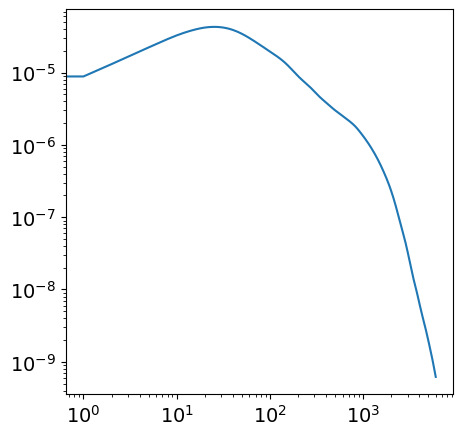

In [59]:
profileemuhm = hm.fft.generic_profile_fft_new(rhos, xs, cmaxs, rss, hcos.zs, hcos.ks)[1]

Pggemu = hcos.get_power_custom(profileemuhm, 'matter',
                               profileemuhm, 'matter', verbose=False)

ls = np.linspace(0, 6000, 6001)

C_gg_emu = hcos.C_gg_new(ls, hcos.zs, hcos.ks, Pggemu, gzs=gzs[1:], gdndz=gdndz)

plt.plot(ls, C_gg_emu)
plt.xscale('log')
plt.yscale('log')
plt.show()